This Jupyter Notebook is used for extracting data from multiple sources. The sources include trip data, occupancy data, and parking lot data. 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np
import os
import folium
from pathlib import Path
import boto3

# import from src
os.chdir('../src')
from trips_data_retrieval import get_agg_trips_by_market, get_agg_trips
import inrix_data_science_utils.maps.quadkey as qkey
from utils import *

# set paths
data_path = Path('../data')

### Extract the 6 Flags Polygon Shapes
#### This might be unnecessary

In [9]:
from polygon_retrieval import get_polygons

# Six Flags
brand_id = 'SG_BRAND_0dd52fbf1cd77fc38e06650435ada07d'
poly_file_name = data_path / 'six_flags_polygons.csv'

In [10]:

if not os.path.exists(poly_file_name):
    polygon_df = get_polygons(brand_id, format='df', echo_query=True)
    relevant_cols = ['location_name', 'top_category', 'sub_category', 'latitude', 'longitude', 'street_address', 'city', 'region', 'postal_code', 'open_hours',
                 'category_tags', 'polygon_wkt', 'polygon_class', 'enclosed', 'is_synthetic', 'includes_parking_lot', 'wkt_area_sq_meters', 'tz', 'year',
                 'month', 'pg_id', 'parking_wkt']
    polygon_df = polygon_df[relevant_cols]
    polygon_df.to_csv(poly_file_name, index=False)
else:
    polygon_df = pd.read_csv(poly_file_name)

In [11]:
# make a new df with just the unique latitude and longitude columns
store_locations_df = polygon_df[['latitude', 'longitude', 'street_address', 'city', 'region']].drop_duplicates()
display(store_locations_df)

six_flag_stores = folium.Map(zoom_start=15)
for i, row in store_locations_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        color='blue',
        radius=4
    ).add_to(six_flag_stores)
six_flag_stores.fit_bounds(six_flag_stores.get_bounds())
six_flag_stores

,latitude,longitude,street_address,city,region
0,43.350715,-73.689007,89 Six Flags Dr,Queensbury,NY
53,42.369309,-87.935103,542 N State Route 21,Gurnee,IL
76,38.906271,-76.776467,13710 Central Ave,Bowie,MD
148,40.141007,-74.438164,1 Six Flags Blvd,Jackson,NJ
334,32.761690,-97.081166,1800 E Lamar Blvd,Arlington,TX
355,35.463453,-97.589371,3908 W Reno Ave,Oklahoma City,OK
359,42.927651,-78.385383,9993 Alleghany Rd,Corfu,NY
403,42.245289,-88.964116,7820 Cherryvale N Blvd,Cherry Valley,IL


In [12]:
# city = 'Oklahoma City'
# test_site = store_locations_df[store_locations_df['city'] == city].iloc[0]
# test_point = test_site['latitude'], test_site['longitude']

# # get the quadkey for a specific location
# qk = qkey.QuadKey('0')
# qk = qk.from_geo(test_point, level=16)
# print(qk)
# qk.show()

#### Map the parking lots at each store

In [13]:
lot_gpd = polygon_df.copy()
geometry = lot_gpd['parking_wkt'].apply(wkt.loads)
lot_gpd = gpd.GeoDataFrame(lot_gpd, crs='epsg:4326', geometry=geometry)
print(lot_gpd.crs)
lot_gpd[lot_gpd['city'] == city].plot(figsize=(6, 6))
plt.show()

epsg:4326


NameError: name 'city' is not defined

In [ ]:
lot_map = folium.Map(zoom_start=10)
cities = lot_gpd['city'].unique()
# add pois to lot map
for city in cities:
    city_gpd = lot_gpd[lot_gpd['city'] == city].copy()
    geom = city_gpd['polygon_wkt'].values[0]
    # convert geom to a shapely geometry object
    geom = wkt.loads(geom)
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'opacity': 0.3})
    folium.Popup(city).add_to(geo_j)
    geo_j.add_to(lot_map)

# add parking lots to lot map
for _, r in lot_gpd.iterrows():
    geom = r['geometry']  # this needs to be a shapely geometry object
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'opacity': 0.8})
    geo_j.add_to(lot_map)
print('loop done')
# lot_map

# neighbors = qk.nearby()
# neighbors.append(str(qk))
# lot_map = add_qks_to_map(lot_map, neighbors)
qk.show(lot_map)
lot_map

### Get the Parking Occupancy Ground Truth Data

In [18]:
from parking_data_retrieval import get_parking_data

Find which cities have the most parking data

In [90]:
destinations = pd.read_csv('../data/valid_parking_destinations.csv')
# sort destinations by num_lots
destinations = destinations.sort_values('num_lots', ascending=False)
display(destinations.head(25))

,pk_destination,str_name,num_lots
19,8faeea56-7a52-11df-ad8f-6b84bf453d3d,Santa Monica,15
16,8faca340-7a52-11df-8a97-875256aaa997,Irvine,11
10,8f98cf00-7a52-11df-bb23-6f961d7daa51,Ann Arbor,9
6,8f8ae430-7a52-11df-93fb-6b6334ed9a2a,Knoxville,7
15,8fa9dfde-7a52-11df-af59-273aa13aeea1,Phoenix,6
14,8fa8608c-7a52-11df-841d-870c5e91ead8,Madison,5
3,8f854570-7a52-11df-9a45-93d95744a90c,Asheville,5
18,8fae86e2-7a52-11df-b2bb-d72f2aaf97c2,Sacramento,4
5,8f8935cc-7a52-11df-85ef-037cba85cd49,Philadelphia,4
9,8f91a77a-7a52-11df-844f-c76b5ffdf7f2,Iowa City,4


In [91]:
destination_name = 'Irvine'
datetime_start = '2022-11-01'  # '2023-01-01'
datetime_end = '2023-03-31' # '2023-01-31'

parking_filename = f'parking_{destination_name}_{datetime_start}_{datetime_end}.csv'

In [111]:
if not os.path.exists(data_path / parking_filename):
    parking_df = get_parking_data(pk_lot=None,
                                  destination_name=destination_name,
                                  datetime_start=datetime_start,
                                  datetime_end=datetime_end,
                                  echo_query=True)
    relevant_cols = ['dt_start_date', 'dt_end_date', 'i_avail', 'i_occ', 'f_pct_occ', 'pk_lot_alias',
                     'f_occupancy_rank', 'pk_lot', 'location', 'geometry']
    parking_df = parking_df[relevant_cols]
    parking_df.to_csv(data_path / parking_filename, index=False)
else:
    parking_df = pd.read_csv(data_path / parking_filename)
parking_df['dt_start_date'] = pd.to_datetime(parking_df['dt_start_date'])
print(parking_df.shape)

(159053, 10)


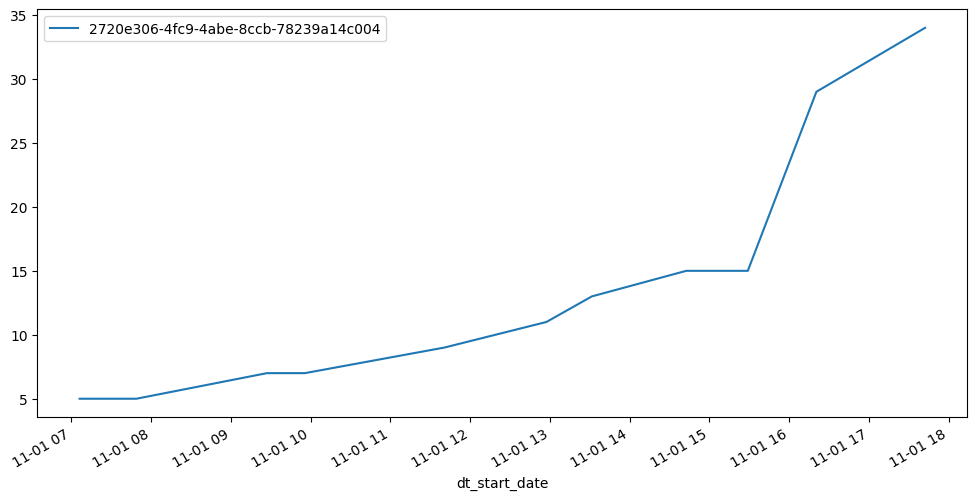

In [112]:
parking_df = parking_df.sort_values('dt_start_date')
day_df = parking_df[(parking_df['pk_lot'] == 375750) & (parking_df['dt_start_date'] < pd.to_datetime('2022-11-07', utc=True))].head(15)

# plot the parking lot occupancy grouped by pk_lot_alias over the dt_start_date x axis
fig, ax = plt.subplots(figsize=(12, 6))
for pk_lot_alias, group in day_df.groupby('pk_lot_alias'):
    group.plot(x='dt_start_date', y='f_pct_occ', ax=ax, label=pk_lot_alias)
plt.show()

# parking_df.head(15)

In [113]:
parking_gpd = parking_df.copy()
geometry = parking_gpd['geometry'].apply(wkt.loads)
parking_gpd = gpd.GeoDataFrame(parking_gpd, crs='epsg:4326', geometry=geometry)

In [114]:
# get the quadkey for a specific location
lot_gpd = parking_gpd.groupby('pk_lot').agg({'geometry': 'first'}).reset_index()
qk = qkey.QuadKey('0')
level = 15
lot_gpd['centroid'] = lot_gpd['geometry'].apply(lambda x: x.centroid)
lot_gpd['center_lat'] = lot_gpd['centroid'].apply(lambda x: x.coords[0][1])
lot_gpd['center_lon'] = lot_gpd['centroid'].apply(lambda x: x.coords[0][0])
lot_gpd['qk'] = lot_gpd.apply(lambda row: qk.from_geo((row['center_lat'], row['center_lon']), level=level), axis=1)

In [115]:
# folium plot the parking lots
m = folium.Map(zoom_start=10)

for _, r in lot_gpd.iterrows():
    geom = r['geometry']  # this needs to be a shapely geometry object
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'opacity': 0.8},
                           tooltip=r['pk_lot'])

    geo_j.add_to(m)


for q in lot_gpd['qk'].unique():
    polygon = folium.GeoJson(data=q.get_bounds_as_geojson(),
                             style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'opacity': 0.3},
                             tooltip=str(q))
    polygon.add_to(m)

m.fit_bounds(m.get_bounds())
m

#### Filter out airport

In [116]:
westmost = parking_gpd['geometry'].bounds['minx'].min()
eastmost = parking_gpd['geometry'].bounds['maxx'].max()
midpoint = (westmost + eastmost) / 2
is_east = parking_gpd['geometry'].centroid.x > midpoint
parking_gpd['is_east'] = is_east

# filter out the parking lots that are west of the midpoint
parking_gpd = parking_gpd[parking_gpd['is_east']]
parking_gpd = parking_gpd.drop(columns=['is_east'])
parking_gpd.to_csv(data_path / 'parking_east.csv''IrvineSpectrumCenter_parking_2022-11_to_2023-03.csv', index=False)
print(parking_gpd.size)

C:\Users\logan.garwood\AppData\Local\Temp\ipykernel_7436\1202762035.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  is_east = parking_gpd['geometry'].centroid.x > midpoint


470460


#### Parking Occupancy Initial Plots

In [107]:
print(parking_gpd['pk_lot'].unique())

[381380 387459 329825 375750 380308 381381]


,dt_start_date,dt_end_date,i_avail,i_occ,f_pct_occ,pk_lot_alias,f_occupancy_rank,pk_lot,location,geometry
86325,2023-01-01 00:23:15.980896+00:00,2023-01-01 04:23:15.980896+00:00,44,NaN,78.0,137a4355-016f-413d-aed7-a06532e25f7d,3.0,381380,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.74 33.651, -117.74 33.651..."
139773,2023-01-01 00:23:16.059244+00:00,2023-01-01 04:23:16.059244+00:00,677,NaN,53.0,1b3dd09b-d8d7-4801-934e-7f90c9c96a63,3.0,387459,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON (((-117.74 33.648, -117.74 33.648..."
124515,2023-01-01 00:23:16.092137+00:00,2023-01-01 04:23:16.092137+00:00,56,NaN,77.0,fe03f4c4-ddc5-4cdc-b4cc-6171ea5584c5,3.0,329825,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74 33.648, -117.74 33.648..."
155421,2023-01-01 00:23:16.125044+00:00,2023-01-01 04:23:16.125044+00:00,58,NaN,74.0,2720e306-4fc9-4abe-8ccb-78239a14c004,3.0,375750,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74 33.648, -117.74 33.648..."
132777,2023-01-01 00:23:16.158122+00:00,2023-01-01 04:23:16.158122+00:00,280,NaN,69.0,5cdc44b3-da43-4c77-aa0d-264d789f0b39,3.0,380308,POINT(-117.744096689923 33.6488428962109),"MULTIPOLYGON (((-117.74 33.65, -117.74 33.649,..."


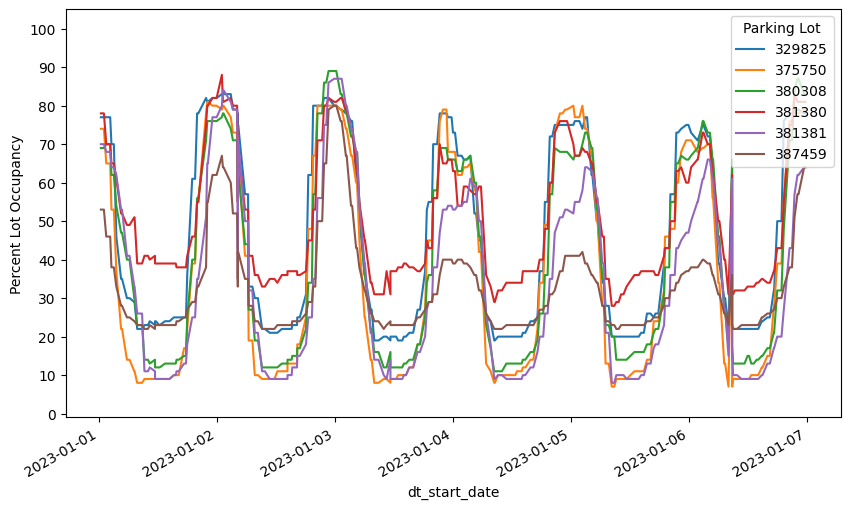

In [99]:
# line graph of f_pct_occ vs. dt_start_date grouped by pk_lot
day_df = parking_gpd[(parking_gpd['dt_start_date'] >= '2023-01-01') &
                    (parking_gpd['dt_start_date'] <= '2023-01-7')] # &
 #(parking_df['pk_lot'] == 381381)]
# order day_df by dt_start_date
day_df = day_df.sort_values('dt_start_date')
display(day_df.head(5))

plt.figure(figsize=(10, 6))
day_df.set_index('dt_start_date', inplace=True)
day_df.groupby('pk_lot')['f_pct_occ'].plot(legend=True)
# plt.plot(day_df['dt_start_date'], day_df['f_pct_occ'])
plt.yticks(np.arange(0, 110, 10))
plt.ylabel('Percent Lot Occupancy')
plt.legend(title='Parking Lot')
plt.ylim(-1, 105)
plt.show()


Smooth into 1 minute buckets

In [100]:
# parking_df['dt_start_date'] = pd.to_datetime(parking_df['dt_start_date'])
# print(parking_df['dt_start_date'].dtype)

In [101]:
# smooth_df = parking_df.sort_values('dt_start_date').copy()
# smooth_df['time_bucket'] = smooth_df['dt_start_date'].dt.floor('min')
# agg_dict = {'f_pct_occ': 'mean', 'i_avail': 'mean', 'i_occ': 'mean',
#             'location': 'first', 'geometry': 'first',}
# grouped_df = smooth_df.groupby(['pk_lot', 'time_bucket']).agg(agg_dict).reset_index()
# # how many rows from the original go into each group of grouped_df

# a, b = smooth_df.shape[0], grouped_df.shape[0]
# print(f'At least {a - b} rows out of {a} from the original\ndf go into each group of grouped_df for a final size of {b}')
# display(grouped_df)

In [109]:
# grouped_df.to_csv(data_path / 'IrvineSpectrumCenter_parking.csv', index=False)
grouped_df = parking_gpd.copy()
grouped_df['time_bucket'] = parking_gpd['dt_start_date']

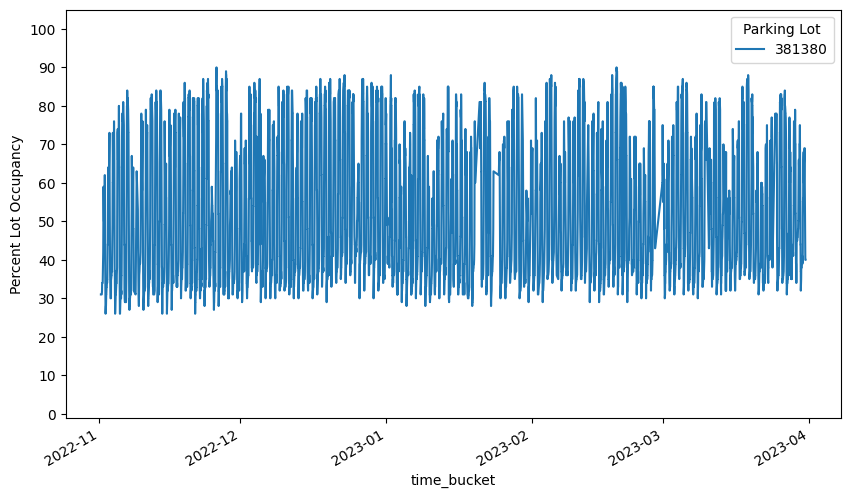

In [110]:
sanity_check = grouped_df[grouped_df['pk_lot'] == 381380] # grouped_df
sanity_check = sanity_check.sort_values('time_bucket')
# display(sanity_check)

plt.figure(figsize=(10, 6))
sanity_check.set_index('time_bucket', inplace=True)
sanity_check.groupby('pk_lot')['f_pct_occ'].plot(legend=True)
# plt.plot(day_df['dt_start_date'], day_df['f_pct_occ'])
plt.yticks(np.arange(0, 110, 10))
plt.ylabel('Percent Lot Occupancy')
plt.legend(title='Parking Lot')
plt.ylim(-1, 105)
plt.show()

### Extracting Trips

In [2]:
# Change these as needed
# qk_list = ['02123003']  # seattle area
# qk_list = ['021230032110033003', '021230032110033012', '021230032110033021', '021230032110033030']  # QFC North Bend
# qk_list = [str(qk)]  # Six Flags OKC
# qk_list = neighbors  # if we want to get all the neighbors data too
qk_list = ['023013202100232', '023013202100233', '023013202102010', '023013202102011'] # Irvine Spectrum Center
start_date = pd.to_datetime('2022-11-01 00:00:00')
end_date = pd.to_datetime('2023-3-31 00:01:00')
trip_type = 'dest' # 'orig' or 'dest'
filename_description = 'IrvineSpectrumCenter'

# don't change these
start_year = str(start_date.year)
start_month = str(start_date.month).zfill(2)
start_day = str(start_date.day).zfill(2)
end_year = str(end_date.year)
end_month = str(end_date.month).zfill(2)
end_day = str(end_date.day).zfill(2)
out_filename = f'''{trip_type}_trips_{filename_description}_{start_year}-{start_month}-{start_day}_to_{
                end_year}-{end_month}-{end_day}.csv'''
out_file_path = data_path / out_filename
print('Will save the csv to ', out_file_path)
origin_qk = (trip_type == 'orig')

table_name = 'tripdata_na_restricted'
s3_tapp_data_dir = 'data-restricted'
s3_tapp_region = 'NA'

Will save the csv to  ..\data\dest_trips_IrvineSpectrumCenter_2022-11-01_to_2023-03-31.csv


In [3]:
# if out_file_path not in the data folder, save it there
if not os.path.exists(out_file_path):
    trips_df = get_agg_trips(
        agg_file_path = out_file_path,
        echo_query=True,
        table_name=table_name,
        start_date=start_date,
        end_date=end_date,
        qk_filter_list=qk_list,
        s3_tapp_data_dir=s3_tapp_data_dir,
        s3_tapp_region=s3_tapp_region,
        origin_qk=origin_qk,
    )
    print('Saved the csv to', out_file_path)
else:
    trips_df = pd.read_csv(out_file_path)

trips_df['date'] = pd.to_datetime(trips_df[['year', 'month', 'day', 'hour', 'minute', 'second']])
display(trips_df)


            WITH qk_counts AS(
            SELECT start_time, provider, start_lat, start_lon, end_lat, end_lon, 
                    BING_TILE_QUADKEY(BING_TILE_AT(end_lat, end_lon, 17)) AS dest_qk17,
                    BING_TILE_QUADKEY(BING_TILE_AT(start_lat, start_lon, 17)) AS orig_qk17,
                    year, month, day, SUBSTR(start_time,12, 2) AS hour, SUBSTR(start_time, 15, 2) AS minute,
                    SUBSTR(start_time, 18, 2) AS second, trip_id, is_moving

            FROM "inrixdatascience"."tripdata_na_restricted"
            WHERE
                qk = '02301'
                AND start_time >= '2022-11-01 00:00:00'
                AND start_time <= '2023-03-31 00:01:00'
                AND provider IN ('458', '475', '470')
                AND REGEXP_LIKE(
                        BING_TILE_QUADKEY(BING_TILE_AT(end_lat, end_lon, 15)),
                        '(023013202100232|023013202100233|023013202102010|023013202102011)'
                    )
                    

,start_time,year,month,day,hour,minute,second,orig_qk17,dest_qk17,start_lat,start_lon,end_lat,end_lon,count,trip_id,is_moving,date
0,2022-11-03 19:42:02.849,2022,11,03,19,42,02,02301320210023211,02301320210023210,33.659078,-117.742921,33.660083,-117.744691,1,ecbc72c1a662f22f88715d255983e31e,1,2022-11-03 19:42:02
1,2022-11-03 04:57:57.220,2022,11,03,04,57,57,02301320210023233,02301320210023222,33.651372,-117.741856,33.652968,-117.750857,1,9d2afa06156180f9093feb269e33976a,1,2022-11-03 04:57:57
2,2022-11-02 23:44:33.000,2022,11,02,23,44,33,02301320210001302,02301320210023232,33.711608,-117.739031,33.651790,-117.743433,1,321992e3f2018b8d9bdfef54656f747b,1,2022-11-02 23:44:33
3,2022-11-11 23:34:08.000,2022,11,11,23,34,08,02301320231000002,02301320210023210,33.427323,-117.596112,33.658896,-117.744039,1,2cafa02bf0d49024b146446fda769956,1,2022-11-11 23:34:08
4,2022-11-11 20:11:48.765,2022,11,11,20,11,48,02301320210231000,02301320210023210,33.612808,-117.706154,33.659447,-117.743491,1,b5c82d45528fc9ac303bab17e20d39bc,1,2022-11-11 20:11:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235020,2022-12-24 01:51:14.000,2022,12,24,01,51,14,02301320210201030,02301320210201021,33.645946,-117.745429,33.646291,-117.746746,1,081c42363e5dbe329e2cccb291c0d56c,1,2022-12-24 01:51:14
235021,2022-12-13 17:15:15.000,2022,12,13,17,15,15,02301320210002032,02301320210201011,33.697360,-117.766004,33.650503,-117.741330,1,d249fea1683d8669c8ec50ff19a521c1,1,2022-12-13 17:15:15
235022,2022-12-13 17:20:06.000,2022,12,13,17,20,06,02301320210003113,02301320210023322,33.702998,-117.730675,33.652396,-117.738276,1,5009173c2446c775ac1c7ff480890720,1,2022-12-13 17:20:06
235023,2022-12-13 22:20:45.000,2022,12,13,22,20,45,02301320210023232,02301320210023323,33.651693,-117.743232,33.651482,-117.735019,1,da50f80d5008317d6027b5a7f028d6a8,1,2022-12-13 22:20:45


In [106]:
# m = lot_map
# m = folium.Map(zoom_start=10)
map = m

N = 10
for i in range(0, trips_df.shape[0], N):
    folium.CircleMarker(
        location=[
            trips_df['end_lat'].values[i],
            trips_df['end_lon'].values[i]
        ],
        color='red',
        radius=1
    ).add_to(map)
# m.fit_bounds(m.get_bounds())

# for i in range(0, trips_df.shape[0], N):
#     folium.CircleMarker(
#         location=[
#             trips_df['start_lat'].values[i],
#             trips_df['start_lon'].values[i]
#         ],
#         color='blue',
#         radius=1
#     ).add_to(map)
# m.fit_bounds(m.get_bounds())

map